In [21]:
from pathlib import Path
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import mne
from mne_bids import BIDSPath, get_entity_vals, read_raw_bids, get_entities_from_fname
from sample_code.utils import _standard_channels

In [37]:
%matplotlib inline

# Dict where keys are group names and values are the label assigned to that group
include_subject_groups = {
    'non-epilepsy': 0,
    'epilepsy-normal': 0,
    'epilepsy-abnormal': 1,
}
# List of subjects to exclude from analysis
exclude_subjects = None

root = Path("D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/40Hz-30")
deriv_root = root / "derivatives"
figures_dir = deriv_root / "figures"

winsize = "1000"
stepsize = "200"
reference = "monopolar"

In [8]:
# Read metadata excel spreadsheet into a dataframe
meta_fpath = Path("D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/JHU_scalp_clinical_datasheet_raw_local.xlsx")
meta_df = pd.read_excel(meta_fpath)

In [11]:
subjects = get_entity_vals(root, 'subject', ignore_subjects=exclude_subjects)
nsubs = len(subjects)
bandpower_root = deriv_root / "band-power" / f"winsize-{winsize}" / f"stepsize-{stepsize}" / reference

# Put spike features into a dict with subject_id keys and spike dict as the values
subject_focal_slowing_map = dict()
for subject in subjects:
    subject_dir = bandpower_root / f"sub-{subject}"
    json_fpath = list(subject_dir.glob("*outliers.json"))[0]
    with open(json_fpath) as f:
        outlier_data = json.load(f)
    subject_focal_slowing_map[subject] = outlier_data


In [13]:
def fill_focal_slowing_map(sparse_focal_slowing_map):
    full_focal_slowing_map = dict()
    for subject, focal_slowing_map in sparse_focal_slowing_map.items():
        full_focal_slowing_map[subject] = _count_focal_slowing_windows(focal_slowing_map)
    return full_focal_slowing_map

In [23]:
def _count_focal_slowing_windows(focal_slowing_map):
    count_dict = dict()
    standard_channels = _standard_channels()
    for ch in standard_channels:
        count_dict[ch] = len(focal_slowing_map.get(ch.upper(), []))
    return count_dict

In [24]:
subject_focal_slowing_counts = fill_focal_slowing_map(subject_focal_slowing_map)

In [30]:
focal_slowing_df = pd.DataFrame.from_dict(subject_focal_slowing_counts, orient='index')
focal_slowing_df['total'] = focal_slowing_df.sum(axis=1)
subject_groups = []
for sub in subjects:
    if int(sub) < 100:
        subject_groups.append(0)
    elif int(sub) > 200:
        subject_groups.append(2)
    else:
        subject_groups.append(1)
focal_slowing_df['group'] = subject_groups

In [31]:
focal_slowing_df

,Fp1,Fp2,F3,F4,F7,F8,P3,P4,C3,C4,...,O1,O2,T3,T4,T5,T6,T7,T8,total,group
001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
226,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
227,0,0,0,0,0,0,0,0,0,0,...,0,0,0,5,0,0,0,0,5,2
228,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


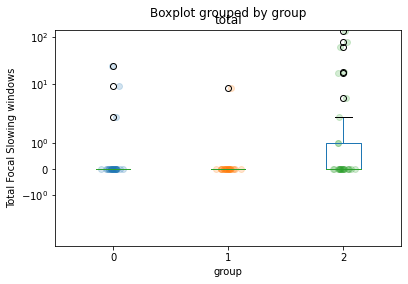

In [42]:
total_focal_slowing_windows = focal_slowing_df['total'].to_list()
groups = subject_groups
group_names = [0, 1, 2]
xticks = [i+1 for i, g in enumerate(group_names)]

fig, ax = plt.subplots()
bp = focal_slowing_df.boxplot(column='total', by='group', grid=False, ax=ax)
for gdx, g in enumerate(group_names):
    focal_slowing_group = [sr for idx, sr in enumerate(total_focal_slowing_windows) if groups[idx] == gdx]
    x = np.random.normal(gdx+1, 0.04, size=len(focal_slowing_group))
    plt.scatter(x, focal_slowing_group, alpha=0.2, label=g)

ax.set_xticks(xticks)
ax.set_xticklabels(group_names)
ax.set_yscale('symlog')
ax.set_ylabel('Total Focal Slowing windows')
plt.show()